## Setup:

# ADS 507: **Flight Analytics**

**US Airport Weather Cancellations ETL**

### Load proper libraries/login variables

In [1]:
import pymysql
import pandas as pd
import sqlite3
import warnings
import seaborn as sns
import numpy as np
import dash
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os 
import folium
from folium import plugins
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import matplotlib.pyplot as plt
from datetime import datetime as dt
import itertools

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

userName = 'sqluser'
userPass = 'password'

### Create a new database 

in which we will create our schema for related tables for our final output

In [2]:
conn=pymysql.connect(host='localhost',port=int(3306), user=userName, passwd=userPass, db='airline')

cur = conn.cursor()

In [ ]:
# Run only once:

cur.execute('CREATE DATABASE domestic_flight_weather_team1')


### Connect to the local copy of airline database:

In [49]:
conn=pymysql.connect(host='localhost',port=int(3306), user=userName, passwd=userPass, db='airline')
tableNames = pd.read_sql_query('Show Tables', conn)
print(tableNames)

           Tables_in_airline
0               l_airline_id
1                  l_airport
2               l_airport_id
3           l_airport_seq_id
4             l_cancellation
5           l_city_market_id
6                l_deparrblk
7       l_distance_group_250
8               l_diversions
9                   l_months
10     l_ontime_delay_groups
11                l_quarters
12      l_state_abr_aviation
13              l_state_fips
14         l_unique_carriers
15                l_weekdays
16        l_world_area_codes
17              l_yesno_resp
18  on_time_performance_2016


### Rename main airline table:

In [5]:
# Run once, and then no more since the name has already been changed:

rename_table = pd.read_sql("ALTER TABLE on_time_on_time_performance_2016_1 RENAME to on_time_performance_2016", conn)
cur = conn.cursor()

cur.execute('ALTER TABLE on_time_on_time_performance_2016_1 RENAME to on_time_performance_2016')
conn.commit()


## Extract Step:

### Extract the AirportCode/City table 'l_airport':

In [52]:
#airportCode_city_query=('SELECT aw.Airport_id, a.Origin, a.OriginCityName, a.OriginState FROM airportcode_weather AS aw JOIN on_time_on_time_performance_2016_1 AS a ON SUBSTRING(Airport_id, 2) = a.Origin;')
#airportCode_City_table = pd.read_sql_query(airportCode_city_query, conn)
#airportCode_City_table.head()
airport_codes_table = pd.read_sql_query('SELECT * FROM l_airport', conn)
airport_codes_table.head()


,Code,Description
0,01A,"Afognak Lake, AK: Afognak Lake Airport"
1,03A,"Granite Mountain, AK: Bear Creek Mining Strip"
2,04A,"Lik, AK: Lik Mining Camp"
3,05A,"Little Squaw, AK: Little Squaw Airport"
4,06A,"Kizhuyak, AK: Kizhuyak Bay"


### Extract AirlineID/Carrier Table into dataframe:

In [ ]:
airlineID_carrier_table = pd.read_sql_query('SELECT * FROM l_airline_id', conn)
airlineID_carrier_table.head()

,Code,Description
0,19031,Mackey International Inc.: MAC
1,19032,Munz Northern Airlines Inc.: XY
2,19033,Cochise Airlines Inc.: COC
3,19034,Golden Gate Airlines Inc.: GSA
4,19035,Aeromech Inc.: RZZ


### Extract Cancellation Code table into dataframe:

In [50]:
CancellationCode_table = pd.read_sql_query('SELECT * FROM l_cancellation', conn)
CancellationCode_table.head()

,Code,Description
0,A,Carrier
1,B,Weather
2,C,National Air System
3,D,Security


### Extract main table on_time_performance_2016:

In [5]:
airline_flights_table = pd.read_sql_query('SELECT * FROM on_time_performance_2016', conn)
airline_flights_table.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,UniqueCarrier,AirlineID,Carrier,TailNum,...,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime
0,2016,1,1,6,3,2016-01-06,AA,19805,AA,N4YBAA,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,7,4,2016-01-07,AA,19805,AA,N434AA,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,8,5,2016-01-08,AA,19805,AA,N541AA,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,9,6,2016-01-09,AA,19805,AA,N489AA,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,10,7,2016-01-10,AA,19805,AA,N439AA,...,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN


In [186]:
airline_flights_table['CRSDepTime'].isna().sum()

0

In [72]:
# Explore Airline data:
airline_flights_table['UniqueCarrier'].unique()

array(['AA', 'AS', 'B6', 'DL', 'F9', 'OO', 'HA', 'NK', 'EV', 'UA', 'WN',
       'VX'], dtype=object)

In [20]:
airline_flights_table.shape

(445827, 83)

### Read in weather csv file:

In [ ]:
### Load the Data in its original form:
WeatherUS = pd.read_csv('WeatherEvents_Jan2016-Dec2021.csv')
WeatherUS = WeatherUS[ WeatherUS[ 'StartTime(UTC)' ].str.contains( '2016' )==True ]
WeatherUS = WeatherUS.drop(['LocationLat','LocationLng','TimeZone','County','ZipCode'], axis=1)
WeatherUS.to_csv('WeatherUS_2016.csv')

In [4]:
Weather_df = pd.read_csv('WeatherUS_2016.csv')
Weather_df.sample(5)

#Airports_df = pd.read_csv('Airports.csv')
#Airports_df.sample(5)

,Unnamed: 0,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
361074,2323200,W-2353446,Rain,Light,2016-10-11 10:15:00,2016-10-11 10:35:00,0.0,US/Central,KBCK,44.2507,-90.8553,Black River Falls,Jackson,WI,54615.0
475251,3009910,W-3049041,Fog,Severe,2016-11-01 08:55:00,2016-11-01 09:55:00,0.0,US/Central,KCQF,30.4600,-87.8770,Fairhope,Baldwin,AL,36532.0
390631,2500754,W-2533384,Fog,Moderate,2016-03-05 14:54:00,2016-03-05 16:54:00,0.0,US/Central,KDEC,39.8308,-88.8719,Decatur,Macon,IL,62521.0
188406,1202166,W-1218054,Fog,Moderate,2016-06-14 02:35:00,2016-06-14 02:55:00,0.0,US/Pacific,KPLU,47.1039,-122.2872,Puyallup,Pierce,WA,98375.0
163244,1040790,W-1054909,Rain,Moderate,2016-01-26 16:58:00,2016-01-26 17:58:00,0.1,US/Central,KCBM,33.6438,-88.4438,Columbus,Lowndes,MS,39705.0


In [75]:
Weather_df.isna().sum()

Unnamed: 0              0
EventId                 0
Type                    0
Severity                0
StartTime(UTC)          0
EndTime(UTC)            0
Precipitation(in)       0
TimeZone                0
AirportCode             0
LocationLat             0
LocationLng             0
City                 1530
County                  0
State                   0
ZipCode              8497
dtype: int64

In [76]:
Weather_df.shape

(1185991, 15)

In [79]:
airline_flights_table['Origin'].isnull().sum()

0

In [82]:
Weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185991 entries, 0 to 1185990
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1185991 non-null  int64  
 1   EventId            1185991 non-null  object 
 2   Type               1185991 non-null  object 
 3   Severity           1185991 non-null  object 
 4   StartTime(UTC)     1185991 non-null  object 
 5   EndTime(UTC)       1185991 non-null  object 
 6   Precipitation(in)  1185991 non-null  float64
 7   TimeZone           1185991 non-null  object 
 8   AirportCode        1185991 non-null  object 
 9   LocationLat        1185991 non-null  float64
 10  LocationLng        1185991 non-null  float64
 11  City               1184461 non-null  object 
 12  County             1185991 non-null  object 
 13  State              1185991 non-null  object 
 14  ZipCode            1177494 non-null  float64
dtypes: float64(4), int64(1), object(

## Transform Step:

### Modify CRSDepTime column in airline database to be in Time format:

In [7]:
airline_flights_table['CRSDepTime'].head(6610)

0       1100
1       1100
2       1100
3       1100
4       1100
        ... 
6605      59
6606      59
6607      59
6608      59
6609      59
Name: CRSDepTime, Length: 6610, dtype: int64

In [8]:
airline_flights_table['FlightDate'].head(6610)

0       2016-01-06
1       2016-01-07
2       2016-01-08
3       2016-01-09
4       2016-01-10
           ...    
6605    2016-01-09
6606    2016-01-11
6607    2016-01-12
6608    2016-01-13
6609    2016-01-14
Name: FlightDate, Length: 6610, dtype: object

In [6]:
# Add zeros to the CRSDepTime column to account for the TIME tranformation that will occur:

airline_flights_table['CRSDepTime'] = airline_flights_table['CRSDepTime'].astype('string')


In [7]:
# Fill CRSDepTime with needed Zeros for time format:

for x in range(0,len(airline_flights_table)):
    if len(airline_flights_table.loc[x,'CRSDepTime']) == 4:
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].ljust(6,'0')
    if len(airline_flights_table.loc[x,'CRSDepTime']) == 2:
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].ljust(4,'0')
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].rjust(6,'0')
    else:
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].ljust(5,'0')
        airline_flights_table.loc[x,'CRSDepTime']=airline_flights_table.loc[x,'CRSDepTime'].rjust(6,'0')



In [8]:
# Change CRSDepTime to TIME format:

#from datetime import datetime as dt


for x in range(len(airline_flights_table)):
    airline_flights_table.loc[x,'CRSDepTime']=pd.to_datetime(airline_flights_table.loc[x,'CRSDepTime'], format='%H%M%S').strftime('%H:%M:%S')

##.dt.strftime('%H:%M:%S')


In [9]:
# COncatenate the FLight Date with CRSDepTIme TIME for flights data:

airline_flights_table['FlightDate'] = airline_flights_table['FlightDate'].astype(str) + ' ' + airline_flights_table['CRSDepTime'].astype(str) 


In [10]:
airline_flights_table['CRSDepTime'].head(6610)

0       11:00:00
1       11:00:00
2       11:00:00
3       11:00:00
4       11:00:00
          ...   
6605    00:59:00
6606    00:59:00
6607    00:59:00
6608    00:59:00
6609    00:59:00
Name: CRSDepTime, Length: 6610, dtype: string

In [11]:
airline_flights_table['FlightDate'].head(6610)

0       2016-01-06 11:00:00
1       2016-01-07 11:00:00
2       2016-01-08 11:00:00
3       2016-01-09 11:00:00
4       2016-01-10 11:00:00
               ...         
6605    2016-01-09 00:59:00
6606    2016-01-11 00:59:00
6607    2016-01-12 00:59:00
6608    2016-01-13 00:59:00
6609    2016-01-14 00:59:00
Name: FlightDate, Length: 6610, dtype: object

### Drop the K in airport codes for Weather dataframe:

In [12]:
#dropping K values in front of the Airport Code Column

Weather_df['AirportCode'] = Weather_df['AirportCode'].str[1:]

Weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


### Clean up Column names in Weather dataframe:

In [13]:
Weather_df.rename(columns = {'StartTime(UTC)':'StartTime_UTC','EndTime(UTC)':'EndTime_UTC'}, inplace = True)


In [ ]:
Weather_df.head()

,Unnamed: 0,EventId,Type,Severity,StartTime_UTC,EndTime_UTC,Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


### Clean up airport dataframe:

In [53]:
airport_codes_table[['City_State', 'Airport']] = airport_codes_table['Description'].str.split(':', expand=True)
airport_codes_table= airport_codes_table.drop('Description', axis=1)
airport_codes_table[['City', 'State']] = airport_codes_table['City_State'].str.split(',', n=1, expand=True)
airport_codes_table= airport_codes_table.drop('City_State', axis=1)


In [54]:
#Weather_df2.to_dict(orient='dict', into=<class 'dict'>)
airport_codes_table.head()

,Code,Airport,City,State
0,01A,Afognak Lake Airport,Afognak Lake,AK
1,03A,Bear Creek Mining Strip,Granite Mountain,AK
2,04A,Lik Mining Camp,Lik,AK
3,05A,Little Squaw Airport,Little Squaw,AK
4,06A,Kizhuyak Bay,Kizhuyak,AK


In [ ]:
airport_codes_table.isna().sum()

Code       0
Airport    1
City       0
State      1
dtype: int64

In [ ]:
row_nulls=airport_codes_table[airport_codes_table['Airport'].isnull()].index.tolist()
#row_nulls=airport_codes_table.isna().index
print(row_nulls)
airport_codes_table.head(row_nulls[0]+1)

[6384]


,Code,Airport,City,State
0,01A,Afognak Lake Airport,Afognak Lake,AK
1,03A,Bear Creek Mining Strip,Granite Mountain,AK
2,04A,Lik Mining Camp,Lik,AK
3,05A,Little Squaw Airport,Little Squaw,AK
4,06A,Kizhuyak Bay,Kizhuyak,AK
...,...,...,...,...
6380,ZXZ,Waterville Airport,Waterville,WA
6381,ZYL,Savannakhet,Sylhet,Bangladesh
6382,ZZU,Mzuzu Airport,Mzuzu,Malawi
6383,ZZV,Zanesville Municipal,Zanesville,OH


In [ ]:
airport_codes_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6385 entries, 0 to 6384
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Code     6385 non-null   object
 1   Airport  6384 non-null   object
 2   City     6385 non-null   object
 3   State    6384 non-null   object
dtypes: object(4)
memory usage: 199.7+ KB


In [ ]:
airport_codes_table.head(1408)

,Code,Airport,City,State
0,01A,Afognak Lake Airport,Afognak Lake,AK
1,03A,Bear Creek Mining Strip,Granite Mountain,AK
2,04A,Lik Mining Camp,Lik,AK
3,05A,Little Squaw Airport,Little Squaw,AK
4,06A,Kizhuyak Bay,Kizhuyak,AK
...,...,...,...,...
1403,DNN,Dalton Municipal,Dalton,GA
1404,DNO,Dianopolis Airport,Dianopolis,Brazil
1405,DNQ,Deniliquin Airport,Deniliquin,Australia
1406,DNR,Dinard Pleurtuit St Malo,Dinard,France


In [ ]:
airport_codes_table.shape

(6385, 4)

In [ ]:
airport_codes_table['City']=airport_codes_table['City'].astype('string')
airport_codes_table['Airport']=airport_codes_table['Airport'].astype('string')
airport_codes_table['State']=airport_codes_table['State'].astype('string')
airport_codes_table['Code']=airport_codes_table['Code'].astype('string')

### Create Weather Type/Severity combinations Weather_code 

In [14]:
Type_unique=Weather_df['Type'].unique()
Severity_unique=Weather_df['Severity'].unique()
print(Type_unique)
print(Severity_unique)

['Snow' 'Fog' 'Cold' 'Storm' 'Rain' 'Precipitation' 'Hail']
['Light' 'Severe' 'Moderate' 'Heavy' 'UNK' 'Other']


In [15]:
#income_range = np.linspace(1,3,3)
#costs_range = np.linspace(1, 3, 3)
#import itertools


all_combinations = list(itertools.product(Type_unique, Severity_unique))
Weather_comb = pd.DataFrame(all_combinations, columns=['Type','Severity'])

In [ ]:
Weather_comb.head()

,Type,Severity
0,Snow,Light
1,Snow,Severe
2,Snow,Moderate
3,Snow,Heavy
4,Snow,UNK


### Add Weather_Code to Weather dataframe:

In [202]:
print(Weather_comb.iloc[1,1])

Severe


In [85]:
Weather_comb.loc[0,'Type']

'Snow'

In [86]:
if (Weather_df.loc[0,'Type'] == 'Snow') & (Weather_df.loc[0,'Severity'] == Weather_comb.loc[0,'Severity']):
    print('hello')

hello


In [16]:
# Runtime is longest here:

weather_code = []

for i in Weather_df.index:
    for x in Weather_comb.index:
        if (Weather_df.loc[i, 'Type'] == Weather_comb.loc[x,'Type']) & (Weather_df.loc[i, 'Severity'] == Weather_comb.loc[x,'Severity']):
            weather_code.append(x)
 
Weather_df['Weather_code'] = weather_code

In [93]:
Weather_comb.shape

(42, 2)

In [17]:
Weather_df['Weather_code'].head(100)

0      0
1      0
2      0
3      0
4      0
      ..
95    24
96    24
97     2
98    24
99    24
Name: Weather_code, Length: 100, dtype: int64

## Load Step:

In [18]:
cur.execute('USE domestic_flight_weather_team1')
conn.commit()

### Load Weather data to continue transformation in SQL:

In [195]:
#Connect to Database
#con = sqlite3.connect('airline') 
cur = conn.cursor()

# Create Table

cur.execute('CREATE TABLE Airport_Weather(EventID INT, WeatherDate_start DATETIME, WeatherDate_end DATETIME, Airport_id VARCHAR(6), Location_lat FLOAT, Location_long FLOAT, weather_code INT, weather_type VARCHAR(30), weather_severity VARCHAR(20), CONSTRAINT weatherEvent PRIMARY KEY (EventID))')
conn.commit()

In [204]:
# Insert data from csv into new table on certain columns:
# Insert Dataframe into SQL Server:

for index, row in Weather_df.iterrows():
     cur.execute("INSERT INTO Airport_Weather (EventID, WeatherDate_start, WeatherDate_end, Airport_id, Location_lat, Location_long, weather_code, weather_type, weather_severity) values(%s,%s,%s,%s,%s,%s,%s,%s,%s)", 
     (index, row.StartTime_UTC, row.EndTime_UTC, row.AirportCode, row.LocationLat, row.LocationLng, row.Weather_code, row.Type, row.Severity))

conn.commit()
cur.close()

### Load Airport code/city/state table in new database:

In [59]:
cur.execute('CREATE TABLE airportID_table(Airport_id VARCHAR(10), Airport VARCHAR(100), City VARCHAR(30), State VARCHAR(100), CONSTRAINT Airport_index PRIMARY KEY (Airport_id))')
conn.commit()

In [60]:
for index, row in airport_codes_table.iterrows():
     cur.execute("INSERT INTO airportID_table (Airport_id, Airport, City, State) values(%s,%s,%s,%s)", 
     (row.Code, row.Airport, row.City, row.State))

conn.commit()


### Load Airline ID table in new database:

In [61]:
cur.execute('CREATE TABLE airline_id_table(Airline_id INT, Airline_name VARCHAR(100), CONSTRAINT Airline_id PRIMARY KEY (Airline_id))')
conn.commit()

In [62]:
for index, row in airlineID_carrier_table.iterrows():
     cur.execute("INSERT INTO airline_id_table (Airline_id, Airline_name) values(%s,%s)", 
     (row.Code, row.Description))

conn.commit()


### Load Cancellation Code table in new database:

In [63]:
cur.execute('CREATE TABLE cancellation_code_table(Cancellation_code CHAR, Cancellation_reason VARCHAR(20), CONSTRAINT Cancellation_code PRIMARY KEY (Cancellation_code))')
conn.commit()

In [64]:
for index, row in CancellationCode_table.iterrows():
     cur.execute("INSERT INTO cancellation_code_table (Cancellation_code, Cancellation_reason) values(%s,%s)", 
     (row.Code, row.Description))

conn.commit()


#### Load Weather Type/Severity Table:

In [190]:
cur.execute('CREATE TABLE Weather_TypeSeverity(TypeSeverity INT, Type VARCHAR(20), Severity VARCHAR(20), CONSTRAINT TypeSeverity PRIMARY KEY (TypeSeverity))')
conn.commit()

In [72]:
for index, row in Weather_comb.iterrows():
     cur.execute("INSERT INTO Weather_TypeSeverity (TypeSeverity, Type, Severity) values(%s,%s,%s)", 
     (index, row.Type, row.Severity))

conn.commit()


In [ ]:
cur.execute('ALTER TABLE Weather_TypeSeverity ADD PRIMARY KEY (TypeSeverity)')
conn.commit()

### Create Table airline_copy with new FlightDate format and only necessary columns loaded into our database:

In [ ]:
cur.execute('CREATE TABLE airline_copy(index_flights INT, FlightDate DATETIME, Airline_id INT, Origin VARCHAR(20), Dest VARCHAR(20), CRSDepTime TIME, Canceled INT, Cancellation_code VARCHAR(2), CONSTRAINT index_flights PRIMARY KEY (index_flights))')
conn.commit()

In [235]:
for index, row in airline_flights_table.iterrows():
     cur.execute("INSERT INTO airline_copy (index_flights,flightDate,Airline_id,Origin,Dest,CRSDepTime,Canceled,Cancellation_code) values(%s,%s,%s,%s,%s,%s,%s,%s)", 
     (index, row.FlightDate, row.AirlineID, row.Origin, row.Dest, row.CRSDepTime, row.Cancelled, row.CancellationCode))

conn.commit()

### Join Flight table with Weather data:

JOIN is based on the AIRPORT code matches between weather data and Origin and Dest in on_time_performance_2016.
Date match has to be BETWEEN the start and end dates of the weather data

In [35]:
cur = conn.cursor()

In [36]:
# Generate Destination flight weather table:

cur.execute('CREATE TABLE Flight_Dest_Weather_Table  AS SELECT a.index_flights, a.FlightDate,  a.Airline_id, a.Dest, m.Location_lat, m.Location_long, a.Canceled, a.Cancellation_code, m.weather_code, m.weather_type as Dest_WeatherType, m.weather_severity as Dest_WeatherSeverity FROM airline_copy as a JOIN airport_weather as m ON a.Dest = m.Airport_id WHERE DATE(a.FlightDate) BETWEEN DATE(m.WeatherDate_start) AND DATE(m.WeatherDate_end)')
conn.commit()

In [38]:
# Attempt to make so only first match for datetime weather information is entered as a row
# to avoid multiple rows with the same flight id:

#(select colors.color WHERE colors.id = ids.id LIMIT 1)
cur.execute('CREATE TABLE Flight_Dest_Weather_Table  AS SELECT a.index_flights, a.FlightDate,  a.Airline_id, a.Dest, m.Location_lat, m.Location_long, a.Canceled, a.Cancellation_code, m.weather_code, m.weather_type as Dest_WeatherType, m.weather_severity as Dest_WeatherSeverity FROM airline_copy as a JOIN airport_weather as m ON a.Dest = m.Airport_id WHERE DATE(a.FlightDate) BETWEEN DATE(m.WeatherDate_start) AND DATE(m.WeatherDate_end) GROUP BY a.index_flights')
conn.commit()

In [39]:
# Add constraints/keys to the table so this connects our main table to the 
# other related tables in the database:

cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD PRIMARY KEY (index_flights)')
conn.commit()            
cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Weather_code) REFERENCES Weather_TypeSeverity (TypeSeverity)')
conn.commit()
cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Airline_id) REFERENCES airline_id_table (Airline_id)')
conn.commit()
cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Cancellation_code) REFERENCES cancellation_code_table (Cancellation_code)')
conn.commit()
cur.execute('ALTER TABLE Flight_Dest_Weather_Table ADD FOREIGN KEY (Dest) REFERENCES airportID_table (Airport_id)')
conn.commit()


In [41]:
# Generate Origin Flight Weather Table:

cur.execute('CREATE TABLE Flight_Origin_Weather_Table  AS SELECT a.index_flights, a.FlightDate,  a.Airline_id, a.Origin, m.Location_lat, m.Location_long, a.Canceled as Cancelled, a.Cancellation_code, m.weather_code, m.weather_type as Origin_WeatherType, m.weather_severity as Origin_WeatherSeverity FROM airline_copy as a JOIN airport_weather as m ON a.Origin = m.Airport_id WHERE DATE(a.FlightDate) BETWEEN DATE(m.WeatherDate_start) AND DATE(m.WeatherDate_end) GROUP BY a.index_flights')
#cur.execute(query_joinORIGIN)
conn.commit()

In [42]:
# Add constraints/keys to the table so this connects our main table to the 
# other related tables in the database:

cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD PRIMARY KEY (index_flights)')
conn.commit()            
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Weather_code) REFERENCES Weather_TypeSeverity (TypeSeverity)')
conn.commit()
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Airline_id) REFERENCES airline_id_table (Airline_id)')
conn.commit()
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Cancellation_code) REFERENCES cancellation_code_table (Cancellation_code)')
conn.commit()
cur.execute('ALTER TABLE Flight_Origin_Weather_Table ADD FOREIGN KEY (Origin) REFERENCES airportID_table (Airport_id)')
conn.commit()

In [187]:
cur.close()

## Visuals:

### EDA/exploratory descriptive visuals

<AxesSubplot:>

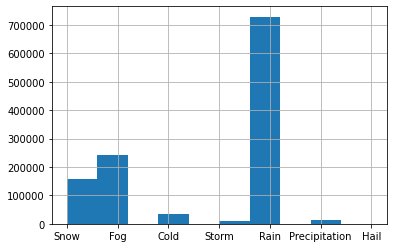

In [48]:
Weather_df["Type"].hist() 

<AxesSubplot:xlabel='Type', ylabel='count'>

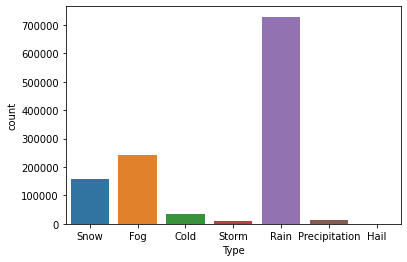

In [62]:
### Visualize the Unique counts (Saba)
sns.countplot(Weather_df['Type'])

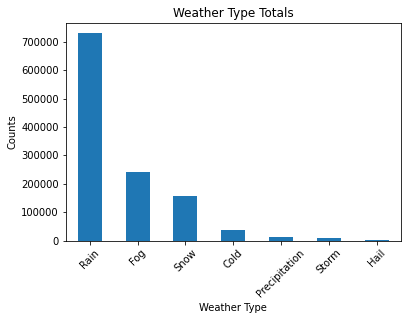

In [264]:
Weather_df['Type'].value_counts().plot(kind='bar')
plt.title('Weather Type Totals')
plt.xlabel('Weather Type')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()



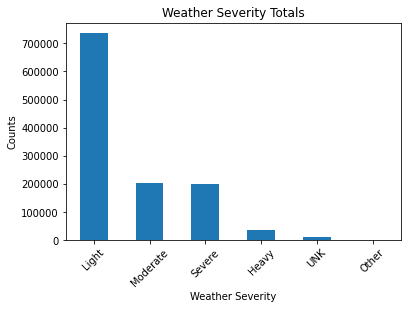

In [265]:
Weather_df['Severity'].value_counts().plot(kind='bar')
plt.title('Weather Severity Totals')
plt.xlabel('Weather Severity')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

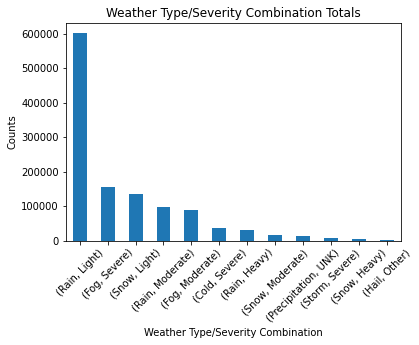

In [267]:
Weather_df[['Type', 'Severity']].value_counts().plot(kind='bar')
plt.title('Weather Type/Severity Combination Totals')
plt.xlabel('Weather Type/Severity Combination')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.show()

### Map Visual

<AxesSubplot:>

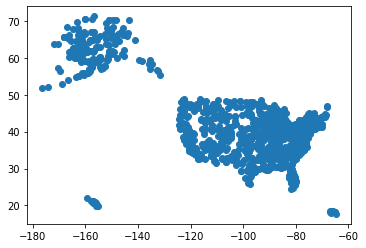

In [19]:
USairports_map = gpd.read_file('data/airp_usa.shp')
USairports_map.plot()

<AxesSubplot:>

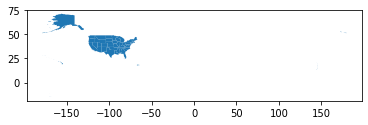

In [20]:
US_map = gpd.read_file('tl_2017_us_state/tl_2017_us_state.shp')
US_map.plot()


Create Dataframe from main flight weather table created as one of the relational database tables

In [21]:
Flight_weather_dataframe = pd.read_sql_query('SELECT * FROM Flight_Origin_Weather_Table', conn)
Flight_weather_dataframe.head()


,index_flights,FlightDate,Airline_id,Origin,Location_lat,Location_long,Canceled,Cancellation_code,weather_code,Origin_tWeatherType,Origin_WeatherSeverity
0,0,2016-01-06 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light
1,1,2016-01-07 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light
2,2,2016-01-08 11:00:00,19805,DFW,32.8974,-97.022,0,None,8,Fog,Moderate
3,3,2016-01-09 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light
4,10,2016-01-16 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light


In [22]:
Flight_weather_dataframe.rename(columns = {'Location_lat':'lat','Location_long':'long'}, inplace = True)


In [24]:
Flight_weather_dataframe.head()

,index_flights,FlightDate,Airline_id,Origin,lat,long,Canceled,Cancellation_code,weather_code,Origin_tWeatherType,Origin_WeatherSeverity
0,0,2016-01-06 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light
1,1,2016-01-07 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light
2,2,2016-01-08 11:00:00,19805,DFW,32.8974,-97.022,0,None,8,Fog,Moderate
3,3,2016-01-09 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light
4,10,2016-01-16 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light


In [ ]:
#State = []

#for i in Flight_weather_dataframe.index:
#    for x in airport_codes_table.index:
#        if Flight_weather_dataframe.loc[i, 'Origin'] == airport_codes_table.loc[x,'Code']:
#            State.append(airport_codes_table.loc[x,'State'])
 
#Flight_weather_dataframe['State'] = State

In [25]:
geometry = [Point(xy) for xy in zip(Flight_weather_dataframe['long'], Flight_weather_dataframe['lat'])]
Flight_weather_dataframe_geo = gpd.GeoDataFrame(Flight_weather_dataframe, 
                          geometry = geometry)

In [26]:
Flight_weather_dataframe_geo.head()

,index_flights,FlightDate,Airline_id,Origin,lat,long,Canceled,Cancellation_code,weather_code,Origin_tWeatherType,Origin_WeatherSeverity,geometry
0,0,2016-01-06 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light,POINT (-97.02200 32.89740)
1,1,2016-01-07 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light,POINT (-97.02200 32.89740)
2,2,2016-01-08 11:00:00,19805,DFW,32.8974,-97.022,0,None,8,Fog,Moderate,POINT (-97.02200 32.89740)
3,3,2016-01-09 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light,POINT (-97.02200 32.89740)
4,10,2016-01-16 11:00:00,19805,DFW,32.8974,-97.022,0,None,24,Rain,Light,POINT (-97.02200 32.89740)


In [35]:
Flight_weather_dataframe_geo['weather_code']=Flight_weather_dataframe_geo['weather_code'].astype('object')

In [56]:
airports_subset=Flight_weather_dataframe_geo[['Origin','FlightDate','Canceled','weather_code','Origin_tWeatherType','Origin_WeatherSeverity']]
airports_mode=airports_subset.groupby(['Origin']).agg(lambda x:x.value_counts().index[0]).reset_index()

#print(Flight_weather_dataframe_geo.groupby(['Origin']).agg(lambda x:x.value_counts()))
airports_mode.head()

,Origin,FlightDate,Canceled,weather_code,Origin_tWeatherType,Origin_WeatherSeverity
0,ABE,2016-01-26 06:00:00,0,8,Fog,Moderate
1,ABQ,2016-01-05 06:00:00,0,24,Rain,Light
2,ABR,2016-01-06 15:28:00,0,0,Snow,Light
3,ABY,2016-01-16 12:00:00,0,24,Rain,Light
4,ACT,2016-01-07 18:26:00,0,7,Fog,Light


In [63]:
airports_subset2=Flight_weather_dataframe_geo[['Origin','lat','long']]
airports_loc=airports_subset2.groupby(['Origin']).agg(lambda x:x.value_counts().index).reset_index()
airports_loc.head()

,Origin,lat,long
0,ABE,40.6499,-75.4477
1,ABQ,35.0417,-106.6150
2,ABR,45.4436,-98.4138
3,ABY,31.5365,-84.1957
4,ACT,31.6180,-97.2283


In [64]:
airports_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Origin  256 non-null    object 
 1   lat     256 non-null    float64
 2   long    256 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.1+ KB


In [65]:
airports_viz=pd.merge(airports_mode, airports_loc, on = "Origin")


In [66]:
geometry = [Point(xy) for xy in zip(airports_viz['long'], airports_viz['lat'])]
airports_viz_geo = gpd.GeoDataFrame(airports_viz, 
                          geometry = geometry)

In [67]:
# Contains top weather type/weather severity and weather code
# for each airport for the month of January 2016:
airports_viz_geo.head()

,Origin,FlightDate,Canceled,weather_code,Origin_tWeatherType,Origin_WeatherSeverity,lat,long,geometry
0,ABE,2016-01-26 06:00:00,0,8,Fog,Moderate,40.6499,-75.4477,POINT (-75.44770 40.64990)
1,ABQ,2016-01-05 06:00:00,0,24,Rain,Light,35.0417,-106.6150,POINT (-106.61500 35.04170)
2,ABR,2016-01-06 15:28:00,0,0,Snow,Light,45.4436,-98.4138,POINT (-98.41380 45.44360)
3,ABY,2016-01-16 12:00:00,0,24,Rain,Light,31.5365,-84.1957,POINT (-84.19570 31.53650)
4,ACT,2016-01-07 18:26:00,0,7,Fog,Light,31.6180,-97.2283,POINT (-97.22830 31.61800)


(20.0, 55.0)

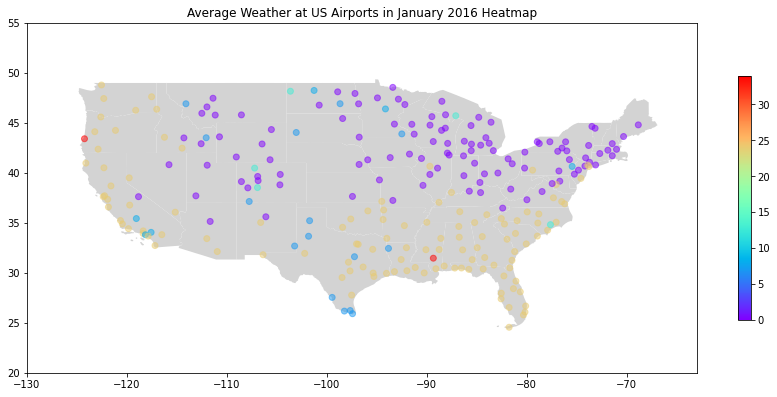

In [70]:
# Plot top weather code in heatmap style on US map for US airports:

fig, ax = plt.subplots(figsize = (15,15))
US_map.plot(ax=ax, color='lightgrey')
airports_viz_geo.plot(column = 'weather_code', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3},
            alpha = .5)
ax.set_title('Average Weather at US Airports in January 2016 Heatmap')
minx, miny, maxx, maxy = [-130,20,-63,55]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

0      Annotation(-75.4477, 40.6499, 'ABE')
1      Annotation(-106.615, 35.0417, 'ABQ')
2      Annotation(-98.4138, 45.4436, 'ABR')
3      Annotation(-84.1957, 31.5365, 'ABY')
4       Annotation(-97.2283, 31.618, 'ACT')
                       ...                 
251    Annotation(-95.4024, 32.3541, 'TYR')
252     Annotation(-83.9857, 35.818, 'TYS')
253    Annotation(-83.2739, 30.7763, 'VLD')
254    Annotation(-86.5254, 30.4833, 'VPS')
255    Annotation(-94.3114, 36.2898, 'XNA')
Length: 256, dtype: object

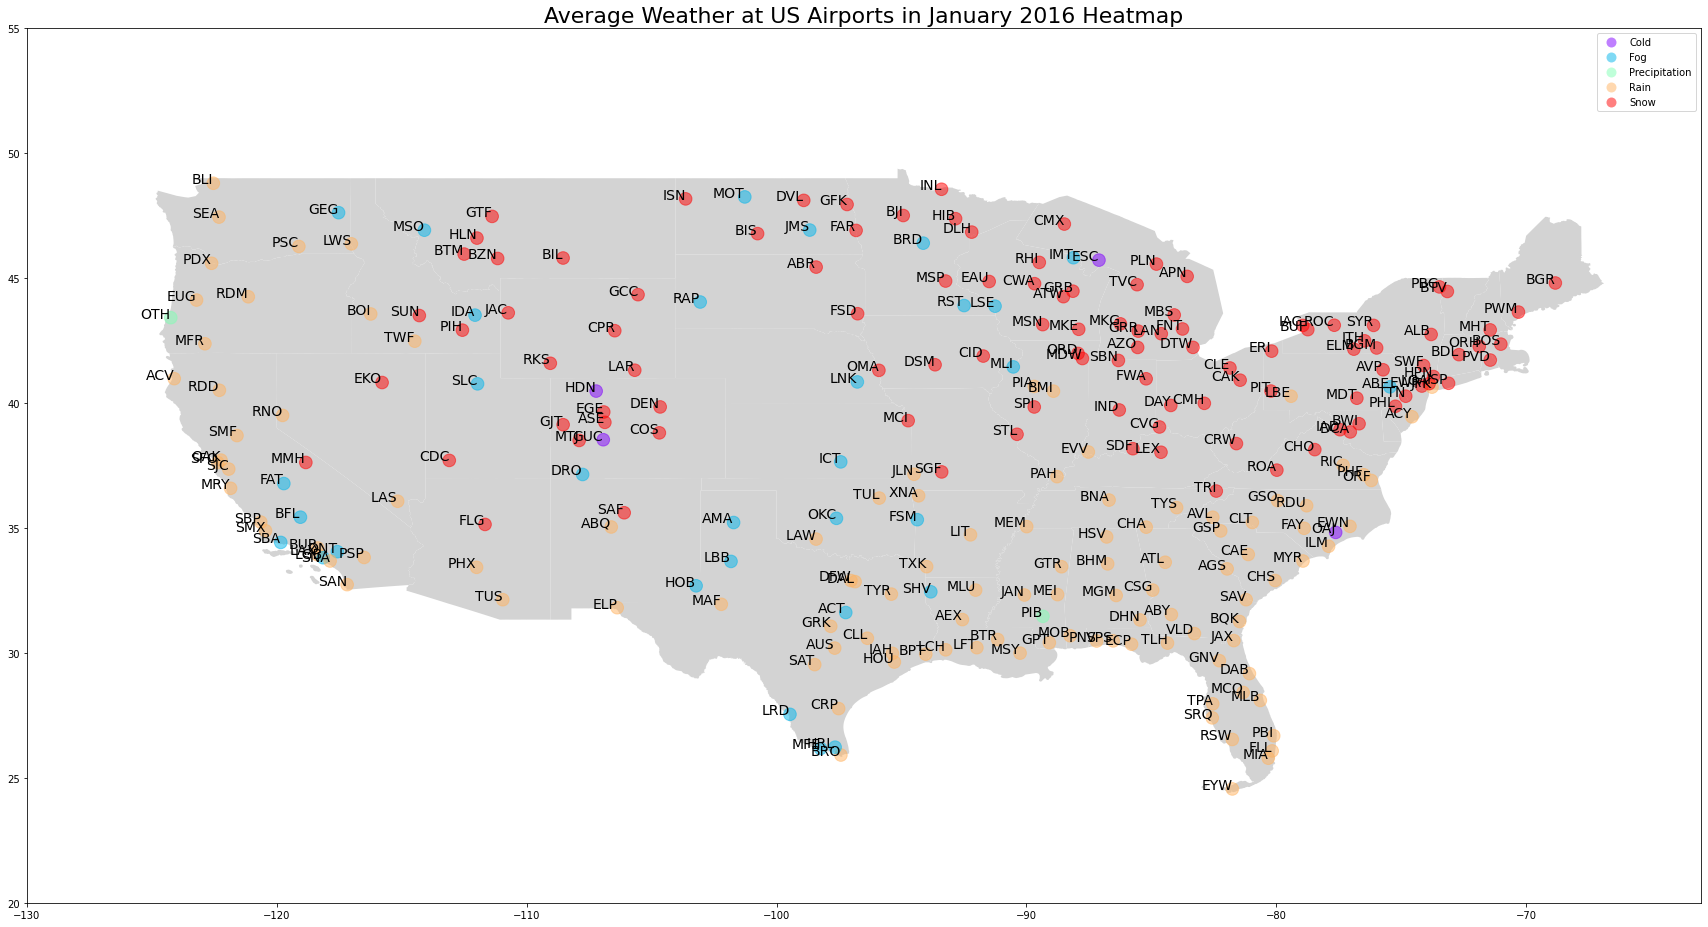

In [115]:
# Plot top weather type on US map for US airports:

fig, ax = plt.subplots(figsize = (30,30))
US_map.plot(ax=ax, color='lightgrey')
airports_viz_geo.plot(column = 'Origin_tWeatherType', ax=ax, colormap='rainbow',
            legend = True, 
            alpha = .5, markersize = 160)
ax.set_title('Average Weather at US Airports in January 2016 Heatmap', fontsize=22)
minx, miny, maxx, maxy = [-130,20,-63,55]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)



# Kind of messy...
# Annotationb of airport location name:
airports_viz_geo.apply(lambda x: ax.annotate(text=x['Origin'], xy=x.geometry.centroid.coords[0], ha='right',
                                             fontsize=14), axis=1)

# Error on this annotation:
#for idx, row in airports_viz_geo.iterrows():
#    ax.annotate(text=row.Origin, xy=row.geometry)

(20.0, 55.0)

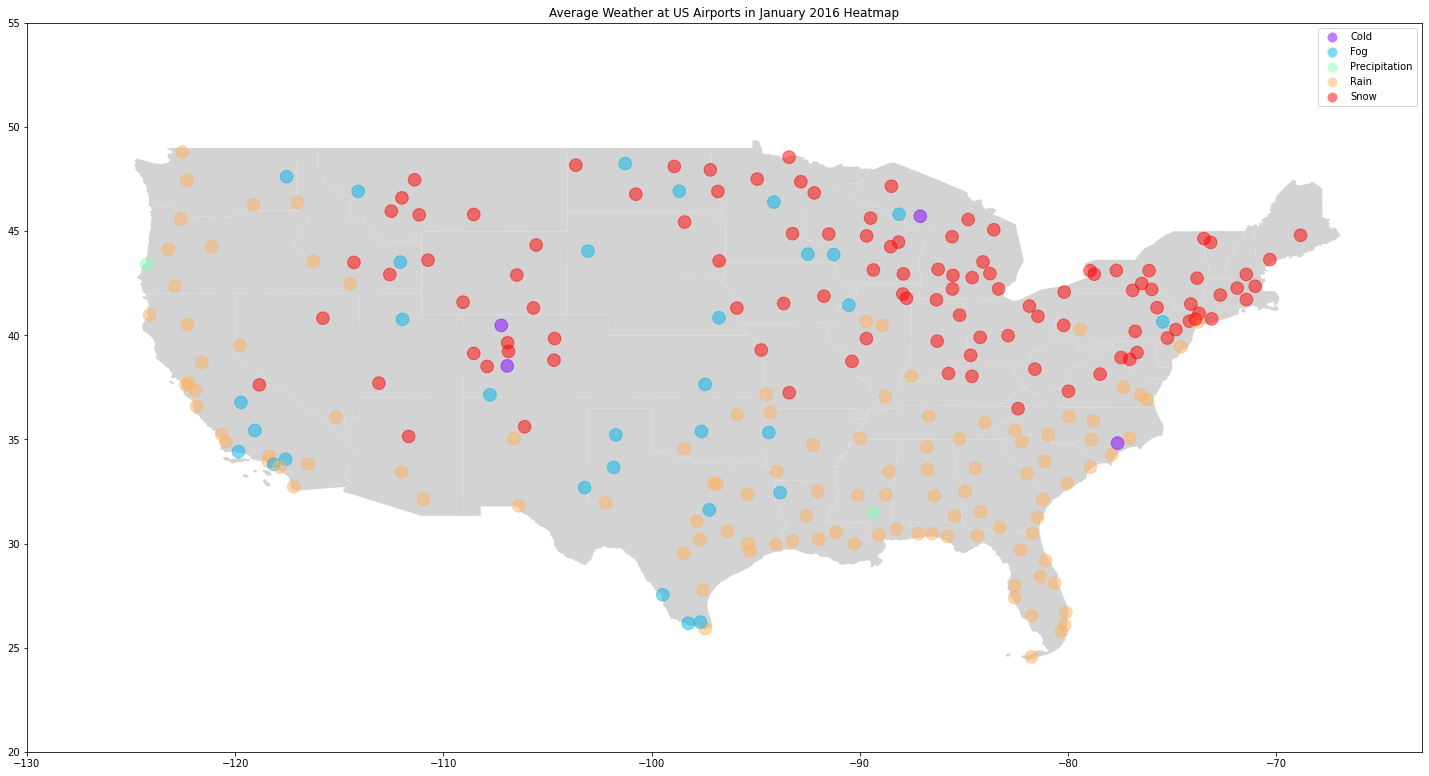

In [98]:
# Plot top weather type on US map for US airports
# without annotations:

fig, ax = plt.subplots(figsize = (25,25))
US_map.plot(ax=ax, color='lightgrey')
airports_viz_geo.plot(column = 'Origin_tWeatherType', ax=ax, colormap='rainbow',
            legend = True,
            alpha = .5, markersize = 160)

ax.set_title('Average Weather at US Airports in January 2016 Heatmap')
minx, miny, maxx, maxy = [-130,20,-63,55]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

### Interactive map

In [125]:
# Import data from EarthPy

data = et.data.get_data('colorado-flood')

# Set working directory to earth-analytics
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [126]:
# Create a map using the Map() function and the coordinates for Boulder, CO
m = folium.Map(location=[40.0150, -105.2705])

# Display the map
m


In [118]:
#Flight_weather_dataframe_geo['Date_Origin_Weather']=Flight_weather_dataframe_geo['FlightDate'].astype(str) + ' ' + Flight_weather_dataframe_geo['Origin'].astype(str) + ' ' + Flight_weather_dataframe_geo['Origin_tWeatherType'].astype(str)

In [119]:
#Flighbt_weather_dataframe_geo.head()

In [123]:
airports_viz_geo['Origin_weatherType']=airports_viz_geo['Origin'].astype(str) + ', ' + airports_viz_geo['Origin_tWeatherType'].astype(str) 

In [124]:
airports_viz_geo.head()

,Origin,FlightDate,Canceled,weather_code,Origin_tWeatherType,Origin_WeatherSeverity,lat,long,geometry,Origin_weatherType
0,ABE,2016-01-26 06:00:00,0,8,Fog,Moderate,40.6499,-75.4477,POINT (-75.44770 40.64990),"ABE, Fog"
1,ABQ,2016-01-05 06:00:00,0,24,Rain,Light,35.0417,-106.6150,POINT (-106.61500 35.04170),"ABQ, Rain"
2,ABR,2016-01-06 15:28:00,0,0,Snow,Light,45.4436,-98.4138,POINT (-98.41380 45.44360),"ABR, Snow"
3,ABY,2016-01-16 12:00:00,0,24,Rain,Light,31.5365,-84.1957,POINT (-84.19570 31.53650),"ABY, Rain"
4,ACT,2016-01-07 18:26:00,0,7,Fog,Light,31.6180,-97.2283,POINT (-97.22830 31.61800),"ACT, Fog"


In [127]:
# Add marker for Boulder, CO

##for index, row in Flight_weather_dataframe_geo.iterrows():
 #   folium.Marker(
 #       location=[Flight_weather_dataframe_geo.loc[0,'lat'], Flight_weather_dataframe_geo.loc[0,'long']], # coordinates for the marker (Earth Lab at CU Boulder)
 #       popup=Flight_weather_dataframe_geo.loc[0,'Date_Origin_Weather'], # pop-up label for the marker
 #       icon=folium.Icon()
 #   ).add_to(m)

for index, row in airports_viz_geo.iterrows():
    folium.Marker(
        location=[row.lat, row.long], # coordinates for the marker (Earth Lab at CU Boulder)
        popup=row.Origin_weatherType,# pop-up label for the marker
        icon=folium.Icon()
    ).add_to(m)

# Display m
m